# Assigment 7
# Tracking and forecasting in conditions of measurement gaps

## Team 6: Berman Vladimir, Dronova Maria, Bazhenov Artem, Skoltech, October, 2022

## Initialisation of libraries 

In [2]:
import matplotlib.pyplot as plt
import numpy as np

## Setting functions

In [3]:
# generating velocity vi and acceleration ai
def gnerate_vel_and_ac(exp, var, T, V0, numb):
    arr = np.zeros(numb)
    a = np.random.normal(exp, var ** 0.5, numb)
    arr[0] = V0
    for i in range(1, len(arr)):
        arr[i] = arr[i - 1] + a[i - 1] * T
    return arr, a

# generating coordinate xi 
def generate_x(T, X0, a, v):
    arr = np.zeros(len(a))
    arr[0] = X0
    for i in range(1, len(a)):
        arr[i] = arr[i - 1] + v[i - 1] * T + a[i - 1] * (T ** 2) / 2
    return arr

# Kalman filter
def kalman_filt(z, X0, P0, F, Q, R, H):
    Xii = np.zeros([200, 2])
    Xiin1 = np.zeros([200, 2])
    Piin1 = np.zeros([200, 2 , 2])
    Pii = np.zeros([200, 2 , 2])
    K = np.zeros([200, 2])
    Xii[0] = X0
    Xiin1[0] = X0
    Pii[0] = P0
    Piin1[0] = P0
    for i in range(len(X)):
        Xiin1[i] = np.dot(F, Xii[i - 1].reshape(2, 1)).reshape(1, 2)
        Piin1[i] = np.dot(np.dot(F, Pii[i - 1]), F.transpose()) + Q

        if np.isnan(z[i]):
            Xii[i] = Xiin1[i]
            Pii[i] = Piin1[i]
        else:
            K[i] = (Piin1[i].dot(H.reshape(2, 1))).dot((((H.reshape(1,2)).dot(Piin1[i])).dot(H.reshape(2, 1)) + R) ** (-1)).reshape(1, 2)
            Xii[i] = Xiin1[i] + K[i] * (z[i] - np.dot(H, Xiin1[i]))
            Pii[i] = (np.identity(2) - (K[i].reshape(2,1)).dot(H.reshape(1,2))).dot(Piin1[i])
        
    return Xii, Pii, Piin1, K
   
# extrapolation       
def extrapol(x, m, F):
    arr = np.array(x)
    F_pow = np.linalg.matrix_power(F, m - 1)
    for i in range(len(x) - m + 1):
        arr[i + m - 1] = F_pow.dot(x[i])
    return arr

# backward smoothing
def backward_smooth(Xii, F, Pii, Piin1):
    x = np.array(Xii)
    Pn = np.array(Pii)
    A = np.zeros([200, 2, 2])
    for i in range(len(x) - 2, -1, -1):
        A[i] = (Pii[i].dot(F.transpose())).dot(np.linalg.inv(Piin1[i]))
        x[i] = Xii[i] + A[i].dot(x[i + 1] - F.dot(Xii[i]))
        Pn[i] = Pii[i] + (A[i].dot(Pn[i + 1] - Piin1[i])).dot(A[i].transpose())
    return x, Pn

## Generating a true trajectory Xi and measurements zi

In [4]:
x0 = 5
v0 = 1
T = 1
sigmaa_2 = 0.2 ** 2
numb = 200
v,a = gnerate_vel_and_ac(0, sigmaa_2 ** 0.5, T, v0, numb)
x = generate_x(T, x0, a, v)
sigmaeta_2 = 20 ** 2
eta = np.random.normal(0, sigmaeta_2 ** 0.5, 200)
F = np.array([[1, T], [0, 1]])
G = np.array([T ** 2 / 2, T])
H = np.array([1, 0])
z = np.zeros(200)
X = np.zeros([200, 2])
X[0] = np.array([x[0], v[0]])
g = np.random.uniform(0, 1, 200)
for i in range(1, len(X)):
    X[i] = np.dot(F, X[i - 1]) + np.dot(G, a[i - 1])
for i in range(len(x)):
    if g[i] <= 0.2:
        z[i] = np.NaN
    else:
        z[i] = np.dot(H, X[i]) + eta[i]
Q = np.dot(np.dot(G, G.transpose()), sigmaa_2)
R = sigmaeta_2
X0 = np.array([5, 1])
P0 = np.array([[1000, 0], [0, 1000]])

## Applying Kalman filter

In [5]:
X_filt, Pii, Piin1, K = kalman_filt(z, X0, P0, F, Q, R, H)

/var/folders/9y/cbn__xb93h3710lq08dsvk9r0000gn/T/ipykernel_59234/3734766940.py:37: RuntimeWarning: invalid value encountered in reciprocal
  K[i] = (Piin1[i].dot(H.reshape(2, 1))).dot((((H.reshape(1,2)).dot(Piin1[i])).dot(H.reshape(2, 1)) + R) ** (-1)).reshape(1, 2)


Text(0.5, 1.0, 'Graph 1\nKalman filter in condition of gaps')

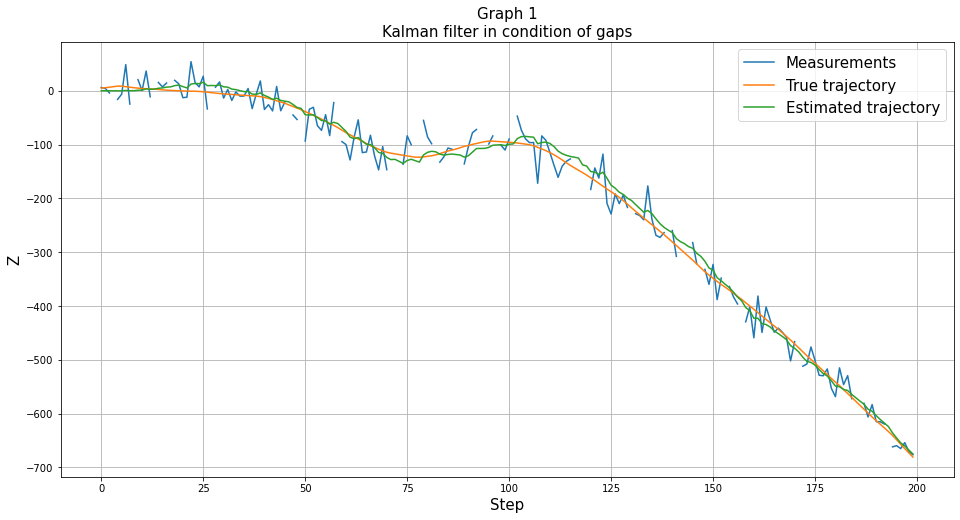

In [6]:
plt.figure(figsize = (16,8))
plt.plot(z)
plt.plot(X[:, 0])
plt.plot(X_filt[:, 0])
plt.grid()
plt.ylabel('Z', fontsize=15)
plt.xlabel('Step', fontsize=15)
plt.legend(['Measurements','True trajectory', 'Estimated trajectory'], fontsize=15)
plt.title('Graph 1\nKalman filter in condition of gaps', fontsize=15)

### Graph above shows that Kalman filter is capable of building a trajectory close to the real one even if 20% of the data is lost.

## Determining errors of estimation 

### Probability of measurement gaps is P = 0.3 for 500 runs

In [17]:
P = np.zeros([500, 200, 2, 2])
P_res1 = np.zeros([200, 2, 2])
err1 = np.zeros([500, 197])
err2 = np.zeros([500, 197])
err3 = np.zeros([500, 197])
P0 = np.array([[100, 0], [0, 100]])
m1 = 7
m2 = 1
p = 0.3
for i in range(500):
    v,a = gnerate_vel_and_ac(0, sigmaa_2 ** 0.5, T, v0, numb)
    X = np.zeros([200, 2])
    X[0] = X0
    for j in range(1, len(X)):
        X[j] = np.dot(F, X[j - 1]) + np.dot(G, a[j - 1]) # generating 1 true trajectory
    z = np.zeros(200)
    eta = np.random.normal(0, sigmaeta_2 ** 0.5, 200)
    g = np.random.uniform(0, 1, 200)
    for k in range(len(g)): # generating 1 bunch of measurements with gaps
        if g[k] <= p:
            z[k] = np.nan
        else:
            z[k] = np.dot(H, X[k]) + eta[k]
    X_filt, P[i] = kalman_filt(z, X0, P0, F, Q, R, H)[:2] # filtrating 1 bunch of measurements
    X_extrapol1 = extrapol(X_filt, m1, F) # extrapolation for 7 steps ahead
    X_extrapol2 = extrapol(X_filt, m2, F) # extrapolation for 1 step ahead
    err1[i] = np.array(X[3:, 0] - X_filt[3:, 0]) ** 2 # calculating filtered error 
    err2[i] = np.array(X[3:, 0] - X_extrapol1[3:, 0]) ** 2 # calculating extrapolated error for 7 steps ahead
    err3[i] = np.array(X[3:, 0] - X_extrapol2[3:, 0]) ** 2 # calculating extrapolated error for 1 step ahead
final_err11 = np.zeros(197) 
final_err12 = np.zeros(197)
final_err13 = np.zeros(197)
for i in range(197):
    final_err11[i] = (np.mean(err1[:, i])) ** 0.5 # calculating mean filtered error of true estimation for every step
    final_err12[i] = (np.mean(err2[:, i])) ** 0.5 # calculating mean extrapolated error of true estimation for 7 steps ahead for every step
    final_err13[i] = (np.mean(err3[:, i])) ** 0.5 # calculating mean extrapolated error of true estimation for 1 step ahead for every step
for i in range(200):
    P_res1[i] = np.mean(P[:,i]) # calculating estimation errors from Kalman for every step 

/var/folders/9y/cbn__xb93h3710lq08dsvk9r0000gn/T/ipykernel_59234/3734766940.py:37: RuntimeWarning: invalid value encountered in reciprocal
  K[i] = (Piin1[i].dot(H.reshape(2, 1))).dot((((H.reshape(1,2)).dot(Piin1[i])).dot(H.reshape(2, 1)) + R) ** (-1)).reshape(1, 2)


-624.4383893608328
-618.7218915954393
-633.7296124759698


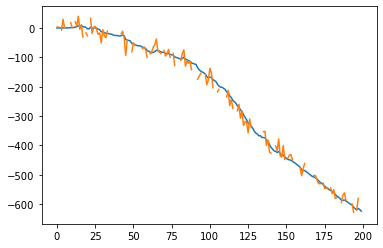

In [18]:
plt.plot(X_filt[:,0])
print(X_filt[-1,0])
print(X_filt[-2,0])
plt.plot(z)
print(z[-1])

Text(0.5, 1.0, 'Graph 2\nErrors considering gap probabiliy P = 0.3')

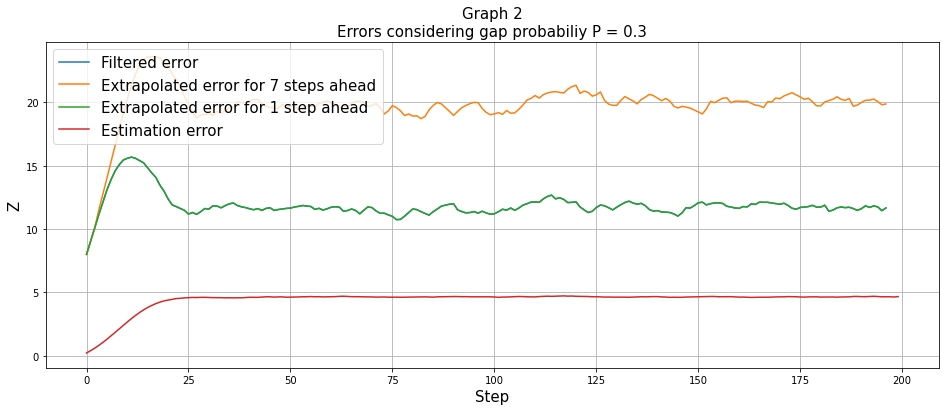

In [19]:
plt.figure(figsize = (16,6))
plt.plot(final_err11)
plt.plot(final_err12)
plt.plot(final_err13)
plt.plot(P_res1[:, 0, 0] ** 0.5)
plt.grid()
plt.ylabel('Z', fontsize=15)
plt.xlabel('Step', fontsize=15)
plt.legend(['Filtered error','Extrapolated error for 7 steps ahead', 'Extrapolated error for 1 step ahead','Estimation error'], fontsize=15)
plt.title('Graph 2\nErrors considering gap probabiliy P = 0.3', fontsize=15)

### Since trajectories after filtration and extrapolation for 1 step ahead are almost coinciding, graphs of filtered errors of estimation and extrapolated error for 1 step ahead are almost the same too. In general, we see the usual siuation: errors calculated from Kalman filter are the lowest, filtered errors are bigger, and errors associated with prediction for some steps ahead are the biggest ones. 

### Probability of measurement gaps is P = 0.5 for 500 runs

In [22]:
P = np.zeros([500, 200, 2, 2])
P_res2 = np.zeros([200, 2, 2])
err1 = np.zeros([500, 197])
err2 = np.zeros([500, 197])
err3 = np.zeros([500, 197])
P0 = np.array([[100, 0], [0, 100]])
m1 = 7
m2 = 1
p = 0.5
for i in range(500):
    v,a = gnerate_vel_and_ac(0, sigmaa_2 ** 0.5, T, v0, numb)
    X = np.zeros([200, 2])
    X[0] = X0
    for j in range(1, len(X)):
        X[j] = np.dot(F, X[j - 1]) + np.dot(G, a[j - 1])
    z = np.zeros(200)
    eta = np.random.normal(0, sigmaeta_2 ** 0.5, 200)
    g = np.random.uniform(0, 1, 200)
    for k in range(len(g)):
        if g[k] <= p:
            z[k] = np.nan
        else:
            z[k] = np.dot(H, X[k]) + eta[k]
    X_filt, P[i] = kalman_filt(z, X0, P0, F, Q, R, H)[:2]
    X_extrapol1 = extrapol(X_filt, m1, F)
    X_extrapol2 = extrapol(X_filt, m2, F)
    err1[i] = np.array(X[3:, 0] - X_filt[3:, 0]) ** 2
    err2[i] = np.array(X[3:, 0] - X_extrapol1[3:, 0]) ** 2
    err3[i] = np.array(X[3:, 0] - X_extrapol2[3:, 0]) ** 2
final_err21 = np.zeros(197)
final_err22 = np.zeros(197)
final_err23 = np.zeros(197)
for i in range(197):
    final_err21[i] = (np.mean(err1[:, i])) ** 0.5
    final_err22[i] = (np.mean(err2[:, i])) ** 0.5
    final_err23[i] = (np.mean(err3[:, i])) ** 0.5
for i in range(200):
    P_res2[i] = np.mean(P[:,i])

/var/folders/9y/cbn__xb93h3710lq08dsvk9r0000gn/T/ipykernel_59234/3734766940.py:37: RuntimeWarning: invalid value encountered in reciprocal
  K[i] = (Piin1[i].dot(H.reshape(2, 1))).dot((((H.reshape(1,2)).dot(Piin1[i])).dot(H.reshape(2, 1)) + R) ** (-1)).reshape(1, 2)


Text(0.5, 1.0, 'Graph 3\nErrors considering gap probabiliy P = 0.5')

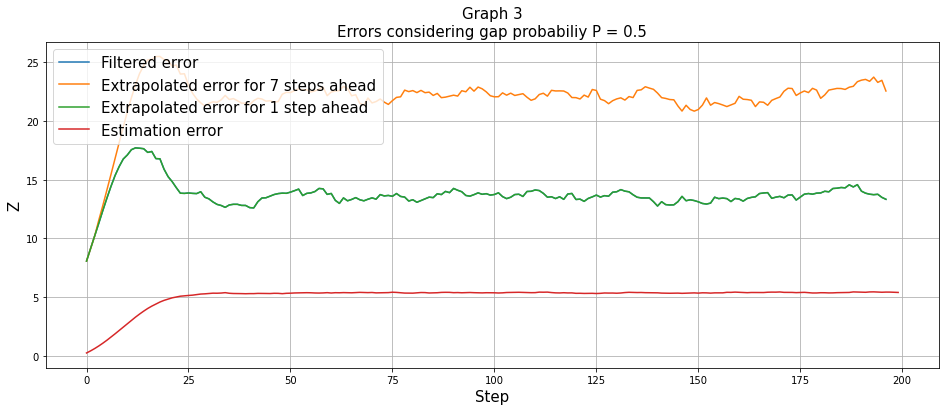

In [23]:
plt.figure(figsize = (16,6))
plt.plot(final_err21)
plt.plot(final_err22)
plt.plot(final_err23)
plt.plot(P_res2[:, 0, 0] ** 0.5)
plt.grid()
plt.ylabel('Z', fontsize=15)
plt.xlabel('Step', fontsize=15)
plt.legend(['Filtered error','Extrapolated error for 7 steps ahead', 'Extrapolated error for 1 step ahead','Estimation error'], fontsize=15)
plt.title('Graph 3\nErrors considering gap probabiliy P = 0.5', fontsize=15)

### Probability of measurement gaps is P = 0.7 for 500 runs

In [26]:
P = np.zeros([500, 200, 2, 2])
P_res3 = np.zeros([200, 2, 2])
err1 = np.zeros([500, 197])
err2 = np.zeros([500, 197])
err3 = np.zeros([500, 197])
P0 = np.array([[100, 0], [0, 100]])
m1 = 7
m2 = 1
p = 0.7
for i in range(500):
    v,a = gnerate_vel_and_ac(0, sigmaa_2 ** 0.5, T, v0, numb)
    X = np.zeros([200, 2])
    X[0] = X0
    for j in range(1, len(X)):
        X[j] = np.dot(F, X[j - 1]) + np.dot(G, a[j - 1])
    z = np.zeros(200)
    eta = np.random.normal(0, sigmaeta_2 ** 0.5, 200)
    g = np.random.uniform(0, 1, 200)
    for k in range(len(g)):
        if g[k] <= p:
            z[k] = np.nan
        else:
            z[k] = np.dot(H, X[k]) + eta[k]
    X_filt, P[i] = kalman_filt(z, X0, P0, F, Q, R, H)[:2]
    X_extrapol1 = extrapol(X_filt, m1, F)
    X_extrapol2 = extrapol(X_filt, m2, F)
    err1[i] = np.array(X[3:, 0] - X_filt[3:, 0]) ** 2
    err2[i] = np.array(X[3:, 0] - X_extrapol1[3:, 0]) ** 2
    err3[i] = np.array(X[3:, 0] - X_extrapol2[3:, 0]) ** 2
final_err31 = np.zeros(197)
final_err32 = np.zeros(197)
final_err33 = np.zeros(197)
for i in range(197):
    final_err31[i] = (np.mean(err1[:, i])) ** 0.5
    final_err32[i] = (np.mean(err2[:, i])) ** 0.5
    final_err33[i] = (np.mean(err3[:, i])) ** 0.5
for i in range(200):
    P_res3[i] = np.mean(P[:,i])

/var/folders/9y/cbn__xb93h3710lq08dsvk9r0000gn/T/ipykernel_59234/3734766940.py:37: RuntimeWarning: invalid value encountered in reciprocal
  K[i] = (Piin1[i].dot(H.reshape(2, 1))).dot((((H.reshape(1,2)).dot(Piin1[i])).dot(H.reshape(2, 1)) + R) ** (-1)).reshape(1, 2)


Text(0.5, 1.0, 'Graph 4\nErrors considering gap probabiliy P = 0.7')

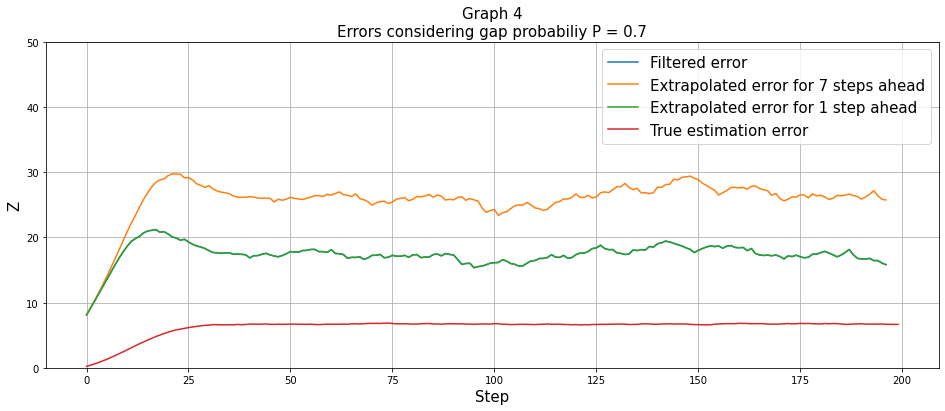

In [27]:
plt.figure(figsize = (16,6))
plt.plot(final_err31)
plt.plot(final_err32)
plt.plot(final_err33)
plt.plot(P_res3[:, 0, 0] ** 0.5)
plt.grid()
plt.ylim([0, 50])
plt.ylabel('Z', fontsize=15)
plt.xlabel('Step', fontsize=15)
plt.legend(['Filtered error','Extrapolated error for 7 steps ahead', 'Extrapolated error for 1 step ahead','True estimation error'], fontsize=15)
plt.title('Graph 4\nErrors considering gap probabiliy P = 0.7', fontsize=15)

### Graphs 3 and 4 indicate that the position of the graphs relative to each other has not changed: lowest errors are the ones calculated from Kalman, then filtered errors, and the biggest ones are errors associated with prediction for 7 steps ahead. The only difference is in the nature of the graphs, as they are less smooth then for probabilIty P = 0.3 (comparison on the graphs 5-7).

Text(0.5, 1.0, 'Graph 5\nFiltered error')

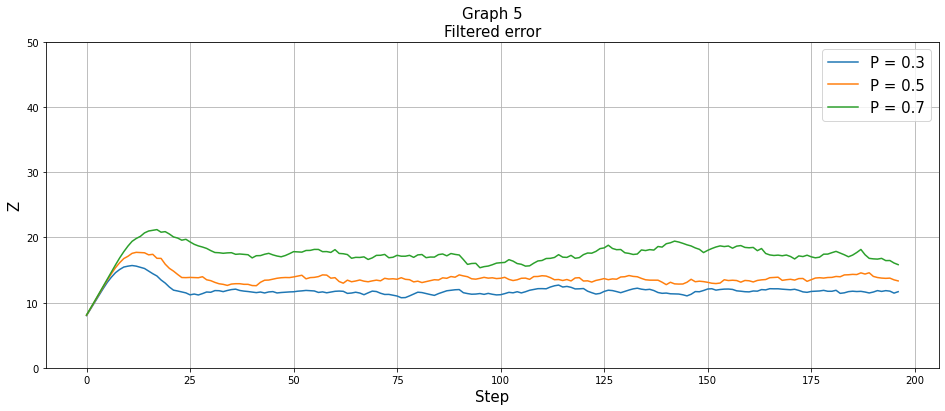

In [28]:
plt.figure(figsize = (16,6))
plt.plot(final_err11)
plt.plot(final_err21)
plt.plot(final_err31)
plt.grid()
plt.ylabel('Z', fontsize=15)
plt.ylim([0, 50])
plt.xlabel('Step', fontsize=15)
plt.legend(['P = 0.3','P = 0.5', 'P = 0.7'], fontsize=15)
plt.title('Graph 5\nFiltered error', fontsize=15)

Text(0.5, 1.0, 'Graph 6\nExtrapolated error for 7 steps ahead')

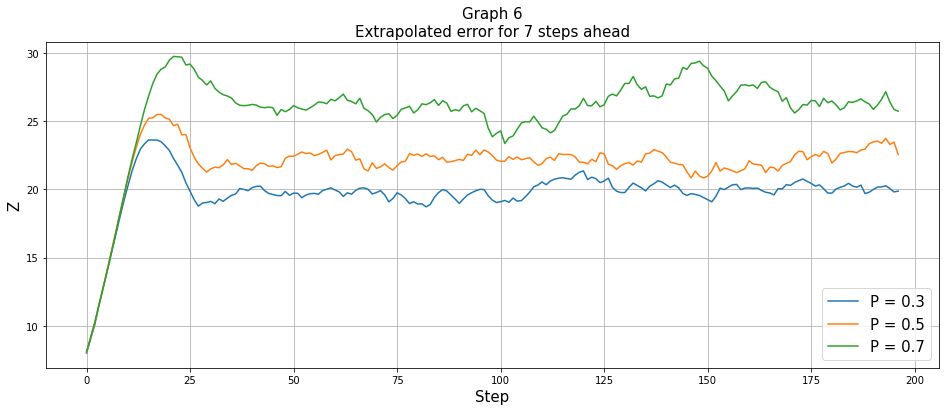

In [29]:
plt.figure(figsize = (16,6))
plt.plot(final_err12)
plt.plot(final_err22)
plt.plot(final_err32)
plt.grid()
plt.ylabel('Z', fontsize=15)
plt.xlabel('Step', fontsize=15)
plt.legend(['P = 0.3','P = 0.5', 'P = 0.7'], fontsize=15)
plt.title('Graph 6\nExtrapolated error for 7 steps ahead', fontsize=15)

Text(0.5, 1.0, 'Graph 7\nExtrapolated error for 1 step ahead')

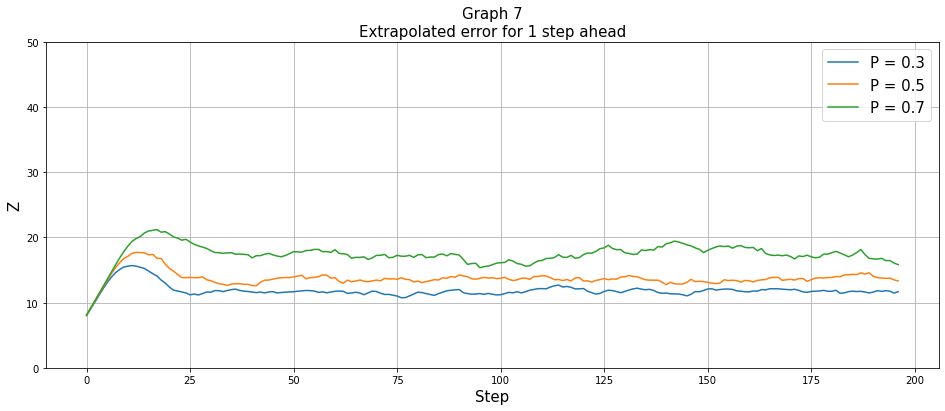

In [30]:
plt.figure(figsize = (16,6))
plt.plot(final_err13)
plt.plot(final_err23)
plt.plot(final_err33)
plt.grid()
plt.ylabel('Z', fontsize=15)
plt.ylim([0, 50])
plt.xlabel('Step', fontsize=15)
plt.legend(['P = 0.3','P = 0.5', 'P = 0.7'], fontsize=15)
plt.title('Graph 7\nExtrapolated error for 1 step ahead', fontsize=15)

Text(0.5, 1.0, 'Graph 8\nEstimation error calcuated from Kalman filter')

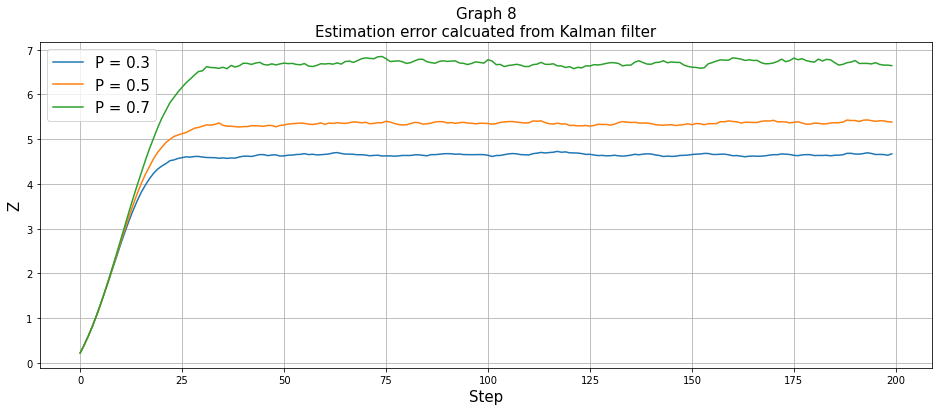

In [31]:
plt.figure(figsize = (16,6))
plt.plot(P_res1[:, 0, 0] ** 0.5)
plt.plot(P_res2[:, 0, 0] ** 0.5)
plt.plot(P_res3[:, 0, 0] ** 0.5)
plt.grid()
plt.ylabel('Z', fontsize=15)
plt.xlabel('Step', fontsize=15)
plt.legend(['P = 0.3','P = 0.5', 'P = 0.7'], fontsize=15)
plt.title('Graph 8\nEstimation error calcuated from Kalman filter', fontsize=15)

## Therefore,

### Graphs 5-8 are made for visualising the difference between all calculated errors. The lowest errors overall are the calculation errors of estimation provided by Kalman filter. Then a bit bigger are filtered errors and extrapolated error for 1 step ahead, that are almost the same value. The bigger the value of steps for prediction, the more significant errors as well. The same correlation is visible for conditions of measurement gaps: with higher probability of gap errors are growing too. 

## Learning log

### Setting functions and applying Kalman filter for trajectory with gaps was carried out by Vladimir Berman. After this step we can say that Kalman filter allows you to get a trajectory of a similar nature to the real one with 1/5 data loss. 
### Determining errors of estimation was made by Artem Bazhenov. Comparison between them, as well as report design, were made by Maria Dronova. From graph 5-8 we can see that biggest errors are obtained for prediction for bigger amount of steps. Also greatest errors values are logically associated with bigger probability of measurement gaps. 